In [0]:
!pip install --upgrade seaborn

In [0]:
import fbprophet

In [0]:
from sklearn.metrics import r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (12, 7.5)

data = pd.read_csv('/home/zuerich-monthly-sunspot-numbers.csv')
data.head()

,Month,Zuerich monthly sunspot numbers 1749-1983
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [4]:
import datetime as dt
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

def prepare_date(month):
  date = str(month) + '-01'
  date = parse(date) + relativedelta(months=1)
  return date - pd.Timedelta(days=1)

frame = data.copy()
frame['ds'] = frame['Month'].apply(prepare_date)
frame['y'] = frame['Zuerich monthly sunspot numbers 1749-1983']
frame.drop(['Month', 'Zuerich monthly sunspot numbers 1749-1983'], axis='columns', inplace=True)
frame.head()

,ds,y
0,1749-01-31,58.0
1,1749-02-28,62.6
2,1749-03-31,70.0
3,1749-04-30,55.7
4,1749-05-31,85.0


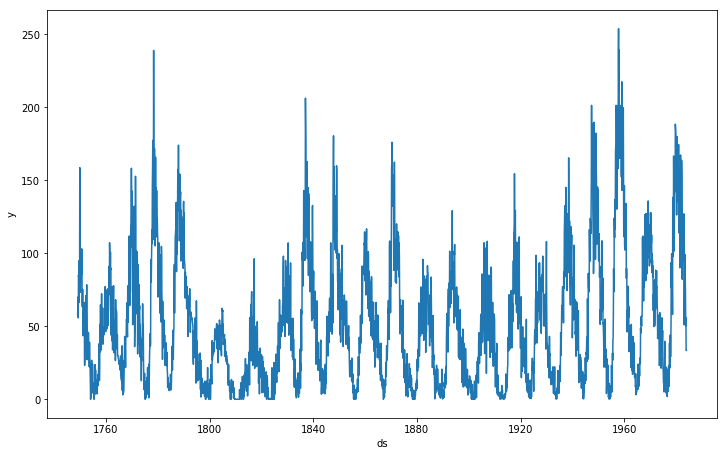

In [5]:
sns.lineplot(x="ds", y="y", data=frame);
plt.savefig('/home/1.png', format='PNG')

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(frame.set_index('ds').y, freq=12);

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


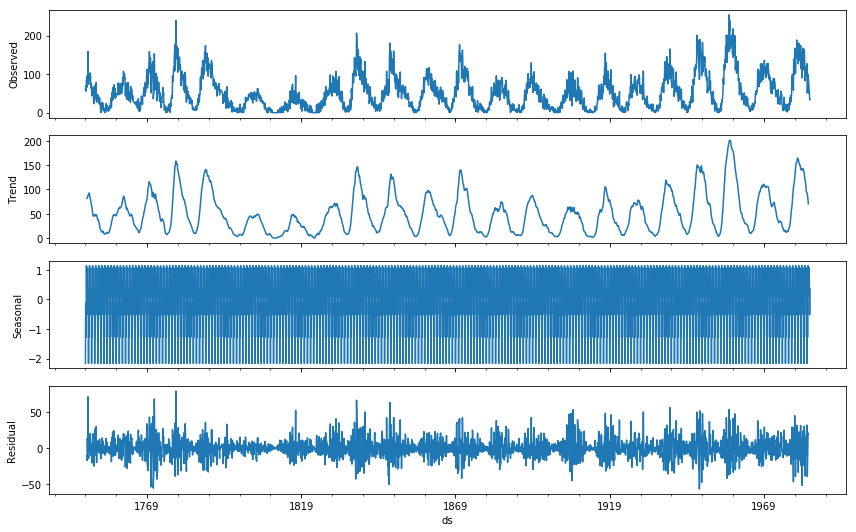

In [7]:
decomposition.plot();
plt.savefig('/home/2.png', format='PNG')

In [0]:
frame = frame.set_index('ds').resample('Y').mean().reset_index()
split = len(frame) - 30
train = frame[:split]
test = frame[split:]

In [0]:
model = fbprophet.Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

model.add_seasonality('spots', 100, fourier_order=22)
model.fit(train)

future_frame = model.make_future_dataframe(periods=len(test), freq='Y')
prediction = model.predict(future_frame)

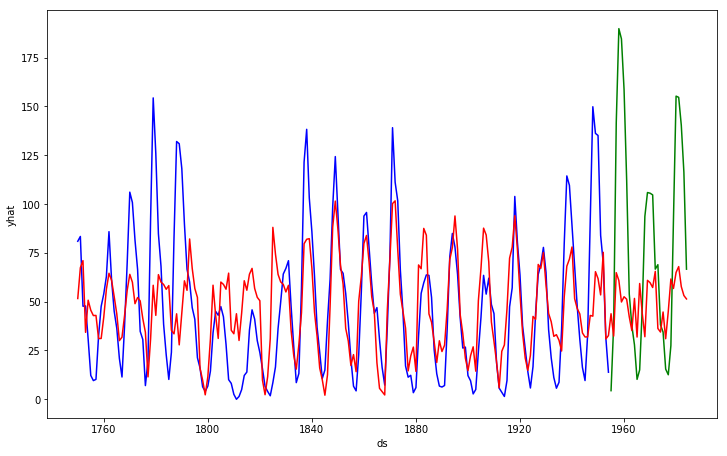

In [10]:
sns.lineplot(x="ds", y="y", data=train, color='blue');
sns.lineplot(x="ds", y="y", data=test, color='green');
sns.lineplot(x="ds", y="yhat", data=prediction, color='red');
plt.savefig('/home/3.png', format='PNG')

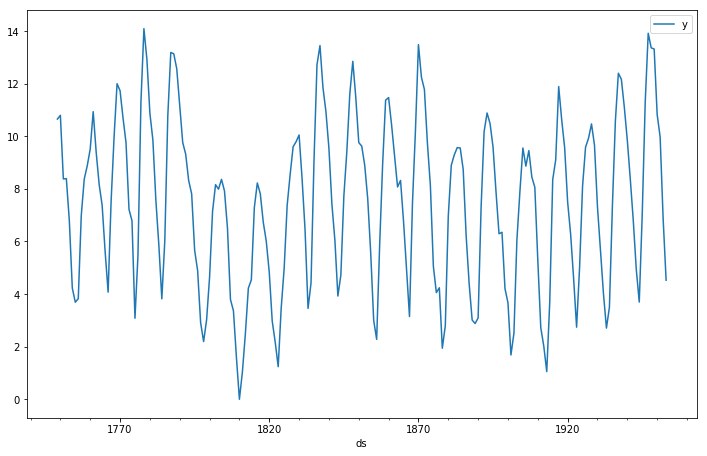

In [11]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

transformed = train.copy(deep=True)
transformed['y'], conversion = boxcox(1 + transformed.y)

transformed.set_index('ds').plot();
plt.savefig('/home/4.png', format='PNG')

In [0]:
model = fbprophet.Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    seasonality_mode='multiplicative'
)

model.add_seasonality('spots', 100, fourier_order=22)
model.fit(transformed[:len(transformed) // 2])

future_frame = model.make_future_dataframe(periods=len(transformed) // 2 + len(test), freq='Y')
prediction = model.predict(future_frame)

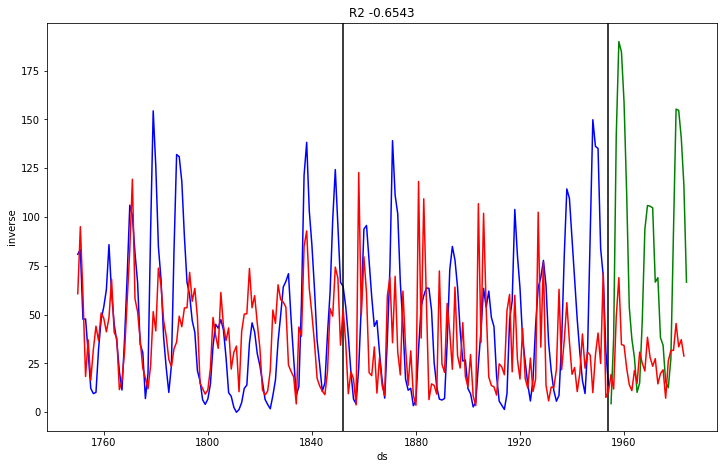

In [13]:
prediction['inverse'] = inv_boxcox(prediction.yhat, conversion) - 1

plt.title('R2 %.4f' % r2_score(test.y, prediction.inverse[-len(test):]));
sns.lineplot(x="ds", y="y", data=train, color='blue');
sns.lineplot(x="ds", y="y", data=test, color='green');
plt.axvline(train['ds'].values[-1], 0, 1, color='black');
plt.axvline(train['ds'].values[len(train) // 2], 0, 1, color='black');
sns.lineplot(x="ds", y="inverse", data=prediction, color='red');
plt.savefig('/home/5.png', format='PNG')

In [14]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [15]:
import keras.backend as K

def make_net(input_shape):
  K.clear_session()
  net = keras.Sequential()
  net.add(keras.layers.GRU(32, input_shape=input_shape, activation='relu'))
  net.add(keras.layers.Dense(32, activation='relu'))
  net.add(keras.layers.Dense(32, activation='relu'))
  net.add(keras.layers.Dense(32, activation='relu'))
  net.add(keras.layers.Dense(1, activation='linear'))
  
  net.compile(loss='mse', optimizer='adam')
  return net


from sklearn.preprocessing import MinMaxScaler

stacked = prediction.yhat

scaler_x = MinMaxScaler(feature_range=(-1, 1)).fit(stacked[:len(train)].values.reshape(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(train[:len(train)].y.values.reshape(-1, 1))
scaled_y = scaler_y.transform(train[:len(train)].y.values.reshape(-1, 1))
samples = np.hstack([
    scaler_x.transform(stacked.values.reshape(-1, 1)),
    2*np.abs(np.cos((prediction.ds.dt.year - prediction.ds.dt.year.min()) / np.pi).values.reshape(-1, 1))-1
]).reshape(-1, 2)

resampled = []
target = []
time = 12
for index in range(0, len(samples) - time):
  resampled.append(samples[index:index + time])
  if (index < len(train) - time):
    target.append(scaled_y.ravel()[index + time])  
resampled = np.resize(np.array(resampled), (len(samples) - 1, time, 2))
print(resampled.shape)
  
regularizer = make_net(input_shape=[time, 2])
regularizer.fit(
    resampled[:len(train) - time],
    target,
    batch_size=4,
    epochs=200,
    verbose=1
)

stacked_fold = regularizer.predict(resampled)
prediction['abscos'] = 50 + 50 * samples.T[1]

Instructions for updating:
Colocations handled automatically by placer.


(233, 12, 2)


Instructions for updating:
Use tf.cast instead.


Epoch 1/200
193/193 [==============================] - 1s 5ms/step - loss: 0.2921
Epoch 2/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1890
Epoch 3/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1703
Epoch 4/200
193/193 [==============================] - 0s 1ms/step - loss: 0.1604
Epoch 5/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1523
Epoch 6/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1359
Epoch 7/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1246
Epoch 8/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1126
Epoch 9/200
193/193 [==============================] - 0s 2ms/step - loss: 0.1117
Epoch 10/200
193/193 [==============================] - 0s 1ms/step - loss: 0.0999
Epoch 11/200
193/193 [==============================] - 0s 2ms/step - loss: 0.0968
Epoch 12/200
193/193 [==============================] - 0s 2ms/step - loss: 0.0922
Epoch 13/200


In [0]:
prediction['stacked'] = [0] + scaler_y.inverse_transform(stacked_fold).ravel().tolist()

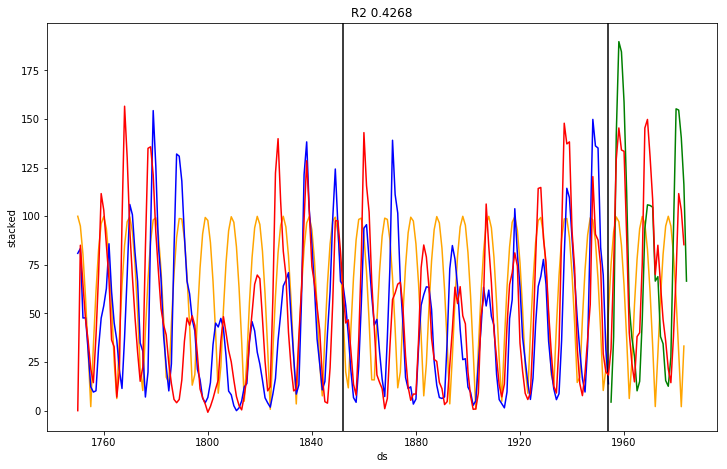

In [17]:
plt.title('R2 %.4f' % r2_score(test.y, prediction.stacked[-len(test):]));
sns.lineplot(x="ds", y="abscos", data=prediction, color='orange');
sns.lineplot(x="ds", y="y", data=train, color='blue');
sns.lineplot(x="ds", y="y", data=test, color='green');
plt.axvline(train['ds'].values[len(train) // 2], 0, 1, color='black');
plt.axvline(train['ds'].values[-1], 0, 1, color='black');
sns.lineplot(x="ds", y="stacked", data=prediction, color='red');
plt.savefig('/home/6.png', format='PNG')